In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math

Представьте, что вы работаете аналитиком, и к вам приходит заказчик с просьбой подготовить анализ проведенного АБ теста.

Механика: при покупке чизбургера в составе комбо клиент получает бонусные баллы по программе лояльности в моб. приложении, которые может в дальнейшем тратить при оплате покупок в Бургер Кинге, т.е. получает cashback в виде баллов.

Заказчик хочет видеть влияние от запуска акции на основные показатели: 

* **ARS** - average retail sales (средняя выручка в день на ресторан, руб)
* **ART** - average retail traffic (среднее кол-во чеков в день на ресторан)
* **ARC** - average retail check (средний чек в день на ресторан, руб)
* **GP**  - gross profit (маржа в день на ресторан, руб)

Он так же просит проверить **изменение средней доли продаж чизбургера**.

In [77]:
ars.head()

,day_id,channel_name,ars,art,art_qnty,gp,food_cost,sales,checks,rest_id,period,group,menu,index,avg_check
0,2021-01-01,Касса,50643.72,145.96,316071.73,12122695.78,7737517.61,22789673.94,65681.38,450,Pre,ТГ,all,0,346.97
2,2021-01-02,Касса,88517.38,226.84,790051.60,30920374.44,19586334.31,58067401.35,148806.36,656,Pre,ТГ,all,2,390.22
3,2021-01-02,Приложение,19118.20,51.92,228941.89,7527269.70,5695808.70,15122500.12,41069.01,660,Pre,ТГ,all,3,368.22
4,2021-01-03,Касса,94474.44,238.10,851088.66,33343935.98,21200775.77,62731029.00,158100.73,664,Pre,ТГ,all,4,396.78
5,2021-01-03,Приложение,21404.27,57.93,263331.03,8583220.46,6573242.66,17337455.67,46922.54,672,Pre,ТГ,all,5,369.49


In [78]:
auv.head()

,day_id,channel_name,action_id,dish_name,market_group,auv,art_qnty,gp,food_cost,sales,period,group,rest_id,index,cheese
0,2021-01-01,Касса,0,БИГ КИНГ ТРЮФЕЛЬ,Основные,2.41,108.34,11192.00,6745.20,20126.11,Pre,ТГ,450,0,0
1,2021-01-01,Касса,0,Балтика 0 Безалкогольное,Напитки,1.41,66.09,2902.45,2596.23,6598.47,Pre,ТГ,450,1,0
2,2021-01-01,Касса,0,Балтика 0 Грейпфрут Безалкогольное,Напитки,1.42,36.84,1623.46,1439.24,3675.30,Pre,ТГ,450,2,0
3,2021-01-01,Касса,0,Беконайзер,Премиальные,2.66,820.12,130284.25,93978.19,250938.10,Pre,ТГ,450,3,0
4,2021-01-01,Касса,0,Биг Кинг,Основные,3.20,963.13,72661.06,52040.32,138555.61,Pre,ТГ,450,4,0



Итак, у нас есть два датасета с продажами касс и моб. приложения:

* ars - данные на уровне день-ресторан
* auv - данные на уровне день-артикул

Атрибуты:

*  **dai_id** - день
* **REST_ID** - id ресторана
* **channel_name** - канал продаж
* **action_id** - отдельная покупка или в составе комбо (0 - отдельная, 1 - комбо)
* **dish_name** - названия блюда, артикула
* **market_group** - категории блюд
* **period** - указание периода теста, где "pre" до начала запуска теста, и "post", соответственно, после запуска
* **group** - контрольная/тестовая группы, где  контрольная осталась без зименений, и в тестовой был запуск акции

Метрики:

* **ARS** - average retail sales (средняя выручка в день на ресторан, руб)
* **ART** - average retail traffic (среднее кол-во чеков в день на ресторан)
* **AUV** - average unit voulme (среднее кол-во проданных едениц в день на ресторан)
* **art_qnty** - article_quantity (кол-во проданных едениц в день)
* **GP** - gross_profit (маржа = продажи - себестоимость)
* **food_cost** - себестоимость, руб
* **sales** - продажи, руб
* **checks** - кол-во чеков

### План работы:  
- [Загрузка и предобработка данных](#step1)
- [Исследовательский анализ данных:](#step2)
    - [Поиск аномалий](#step3)
    - [Анализ показателей до и после запуска теста:](#step4)
        - [ARS - average retail sales (средняя выручка в день на ресторан, руб)](#step5)
        - [ART - average retail traffic (среднее кол-во чеков в день на ресторан)](#step6)
        - [ARC - average retail check (средний чек в день на ресторан, руб)](#step7)
        - [GP - gross profit (маржа в день на ресторан, руб)](#step8)
        - [Изменение средней доли продаж чизбургера](#step9)
        - ["Конверсия в комбо-чизбургеры" (долю чизбургров в составе комбо)](#step10)
- [Проверка гипотез:](#step11)
    - [Z - критерий для разницы долей покупок чизбургеров в комбо](#step12)
    - [Непараметрический тест Уилкоксона-Манна-Уитни:](#step13)
        - [ARS - average retail sales (средняя выручка в день на ресторан, руб)](#step14)
        - [ART - average retail traffic (среднее кол-во чеков в день на ресторан)](#step15)
        - [ARC - average retail check (средний чек в день на ресторан, руб)](#step16)
        - [GP - gross profit (маржа в день на ресторан, руб)](#step17)
        - [Изменение средней доли продаж чизбургера](#step18)
- [Вывод](#step19)

## Загрузка и предобработка данных<a id="step1">

In [7]:
ars = pd.read_csv('interview_case_BK_ars').drop(columns='Unnamed: 0')
auv = pd.read_csv('interview_case_BK_auv').drop(columns='Unnamed: 0')

In [8]:
ars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DAY_ID        122 non-null    object 
 1   channel_name  122 non-null    object 
 2   ARS           122 non-null    float64
 3   ART           122 non-null    float64
 4   art_qnty      122 non-null    float64
 5   GP            122 non-null    float64
 6   food_cost     122 non-null    float64
 7   sales         122 non-null    float64
 8   checks        122 non-null    float64
 9   REST_ID       122 non-null    int64  
 10  period        122 non-null    object 
 11  group         122 non-null    object 
 12  menu          122 non-null    object 
dtypes: float64(7), int64(1), object(5)
memory usage: 12.5+ KB


In [9]:
auv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34126 entries, 0 to 34125
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   day_id        34126 non-null  object 
 1   channel_name  34126 non-null  object 
 2   action_id     34126 non-null  int64  
 3   dish_name     34126 non-null  object 
 4   market_group  34126 non-null  object 
 5   AUV           34126 non-null  float64
 6   art_qnty      34126 non-null  float64
 7   GP            34126 non-null  float64
 8   food_cost     34126 non-null  float64
 9   sales         34126 non-null  float64
 10  period        34126 non-null  object 
 11  group         34126 non-null  object 
dtypes: float64(5), int64(1), object(6)
memory usage: 3.1+ MB


Приведем столбцы с датами к типу datetime. 

In [10]:
ars['DAY_ID'] = pd.to_datetime(ars['DAY_ID'], format=('%Y-%m-%d'))
auv['day_id'] = pd.to_datetime(auv['day_id'], format=('%Y-%m-%d'))

In [11]:
#приведем названия столбцов к нижнему регистру
ars.columns = ars.columns.str.lower()
auv.columns = auv.columns.str.lower()

Интервалы совпадают

Проверим таблицы на наличие полных дубликатов

In [12]:
print('Полных дубликатов: ', ars.duplicated().sum())
print('Полных дубликатов: ', auv.duplicated().sum())

Полных дубликатов:  0
Полных дубликатов:  0


#### Связь двух таблиц 

Проверим в одном ли временном интервале находятся данные в таблицах

In [13]:
ars['day_id'].describe()

count                     122
unique                     61
top       2021-01-12 00:00:00
freq                        2
first     2021-01-01 00:00:00
last      2021-03-02 00:00:00
Name: day_id, dtype: object

In [14]:
auv['day_id'].describe()

count                   34126
unique                     61
top       2021-02-22 00:00:00
freq                      571
first     2021-01-01 00:00:00
last      2021-03-02 00:00:00
Name: day_id, dtype: object

In [15]:
#проверим соответствует ли количество записей с каналами каждой дате в соотношении 1 касса и 1 приложение
#сначала сохраним индекс в столбец, чтобы получить уникальные id строк
ars['index'] = ars.index
a = ars.groupby(['day_id', 'channel_name']).agg({'index':'nunique'}).reset_index()
a['index'].value_counts()

1    122
Name: index, dtype: int64

Каждой дате в таблице `ars` соответствует 1 запись Касса и 1 запись Приложение.
Поэтому делаем вывод, что таблицы `ars` и `auv` связаны составным ключом по столбцам `day_id` и `channel_name`.  
Добавим в таблицу `auv` столбец `rest_id` из таблицы `ars`.

In [16]:
day_channel_rest = ars.loc[:, ['day_id', 'channel_name', 'rest_id']]
day_channel_rest['rest_id'].nunique()

41

In [17]:
auv = auv.merge(day_channel_rest, how='left', on=['day_id', 'channel_name'])

Посмотрим на количество значений в периодах pre, post. И какие группы в них входят

In [18]:
ars.groupby(['period', 'group']).agg({'index':'count'})

,,index
period,group,
Post,ТГ,60
Pre,ТГ,62


Соотношение примерно одинаковое, данные есть только по тестовой группе до и после теста.

Проверим пересечение rest_id в группах Post и Pre

In [19]:
a = pd.Series(ars[ars['period'] == 'Post']['rest_id'].unique())
b = pd.Series(ars[ars['period'] == 'Pre']['rest_id'].unique())
a_b = pd.concat([a, b])
a_b[a_b.duplicated() == True]

9     675
13    678
14    679
15    677
18    681
dtype: int64

In [20]:
ars[ars['period']=='Pre']['day_id'].describe()

count                      62
unique                     31
top       2021-01-12 00:00:00
freq                        2
first     2021-01-01 00:00:00
last      2021-01-31 00:00:00
Name: day_id, dtype: object

In [21]:
ars[ars['period']=='Post']['day_id'].describe()

count                      60
unique                     30
top       2021-02-12 00:00:00
freq                        2
first     2021-02-01 00:00:00
last      2021-03-02 00:00:00
Name: day_id, dtype: object

Пересечения есть, но так как даты периодов не пересекаются, это неважно.

## Исследовательский анализ данных<a id="step2">

### Поиск аномалий<a id="step3">

Так как аномальные значения могут сильно исказить тезультаты теста, их следует исключить.  
Искать будем только в таблице `auv`, так как там много информации по транзакциям. А в таблице `ars` уже агрегорованные данные и всего 122 строки, будем считать, что они уже предобработаны и не содержат аномалии.
Проверять будем среднее кол-во проданных едениц продукции в день на ресторан `auv`.   
Для этого посмотрим на распределение этих значений и посчитаем выборочные перцентили.

#### Для продаж через кассу

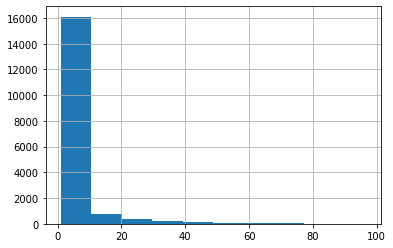

In [22]:
auv[auv['channel_name'] == 'Касса']['auv'].hist();

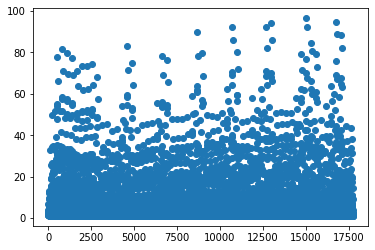

In [23]:
y_c = auv[auv['channel_name'] == 'Касса']['auv']
x_values = pd.Series(range(0, len(y_c)))
plt.scatter(x_values, y_c);

На графиках видно, что в данных есть аномальные значения.  
Посчитаем процентиль, чтобы определить верхнюю границу значений

In [24]:
np.percentile(y_c, [95, 97, 99])

array([19.69 , 28.862, 47.042])

97% записей продаж через Кассы содержат не более 28 чизбургеров в день на ресторан. Будем считать это верхней границей. Удалим те строки, которые выше нее.  

#### Для продаж через приложение

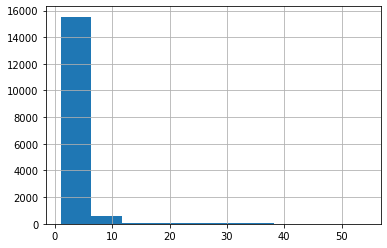

In [25]:
auv[auv['channel_name'] == 'Приложение']['auv'].hist();

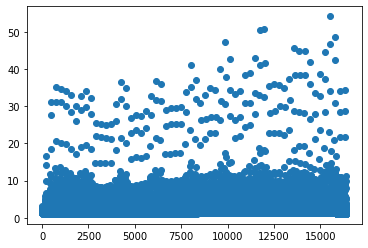

In [26]:
y_a = auv[auv['channel_name'] == 'Приложение']['auv']
x_values = pd.Series(range(0, len(y_a)))
plt.scatter(x_values, y_a);

На графиках видно, что в данных есть аномальные значения.  
Посчитаем процентиль, чтобы определить верхнюю границу значений

In [27]:
np.percentile(y_a, [95, 97, 99])

array([ 6.728 ,  9.1188, 19.198 ])

97% записей продаж через приложение содержат не более 9 чизбургеров в день на ресторан. Будем считать это верхней границей. Удалим те строки, которые выше нее.  

In [28]:
auv = auv[((auv['channel_name'] == 'Касса') & (auv['auv'] <= 28)) 
    | ((auv['channel_name'] == 'Приложение') & (auv['auv'] <= 9))]

In [29]:
print(auv[auv['period']=='Post']['rest_id'].nunique())
print(ars[ars['period']=='Post']['rest_id'].nunique())
print(auv[auv['period']=='Pre']['rest_id'].nunique())
print(ars[ars['period']=='Pre']['rest_id'].nunique())

27
27
19
19


Аномалии удалили, все рестораны остались на месте. 

### Анализ показателей до и после запуска теста<a id="step4">

#### ARS - average retail sales (средняя выручка в день на ресторан, руб)<a id="step5">

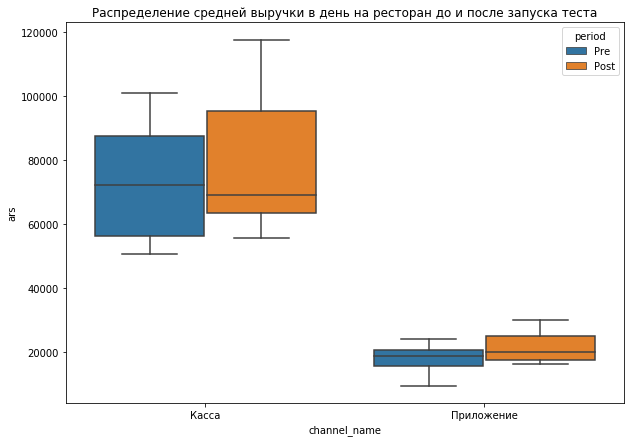

In [30]:
plt.figure(figsize=(10, 7))
plt.title('Распределение средней выручки в день на ресторан до и после запуска теста')
sns.boxplot(x='channel_name', y='ars', hue='period', data=ars);

Визуально на графиках видно, что средняя выручки увеличился после запуска теста.  
Нужно проверить гипотезу о равенстве значений.

#### ART - average retail traffic (среднее кол-во чеков в день на ресторан)<a id="step6">

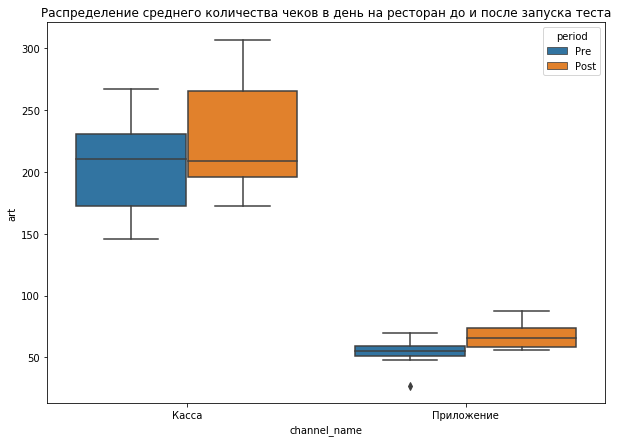

In [31]:
plt.figure(figsize=(10, 7))
plt.title('Распределение среднего количества чеков в день на ресторан до и после запуска теста')
sns.boxplot(x='channel_name', y='art', hue='period', data=ars);

Визуально на графиках видно, что среднее количество чеков в день на ресторан увеличилось после запуска теста.  
Нужно проверить гипотезу о раенстве значений.

На графике виден выброс, найдем его.

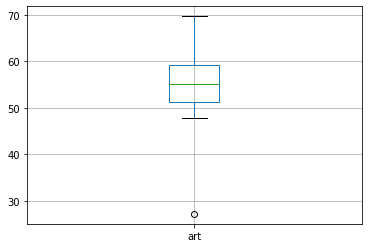

In [32]:
ars[(ars['channel_name'] == 'Приложение') & (ars['period'] == 'Pre')].boxplot(column=['art']);

In [33]:
ars[ars['art'] < 30]

,day_id,channel_name,ars,art,art_qnty,gp,food_cost,sales,checks,rest_id,period,group,menu,index
1,2021-01-01,Приложение,9428.85,27.16,78976.96,2572642.13,1963059.69,5176440.43,14908.48,454,Pre,ТГ,all,1


Удалим запись `day_id = 2021-01-01, channel_name Приложение, rest_id = 454, art < 30 ` из таблиц как аномальную.

In [34]:
ars = ars[ars['art'] > 30]

In [35]:
auv['index'] = auv.index

In [36]:
drop_index = auv[(auv['channel_name'] == 'Приложение') & (auv['day_id'] == '2021-01-01') 
    & (auv['rest_id'] == 454)].index.tolist()

In [37]:
#удалим все записи с индексами, которые соответствуют индексам из списка drop_index
#получим, что Post = 60 ресторанов, а Pre = 61 ресторан (вместо 62, тк 1 исключили)
auv = auv.query('index != @drop_index')

#### ARC - average retail check (средний чек в день на ресторан, руб)<a id="step7">

Посчитаем средний чек

In [38]:
ars['avg_check'] = (ars['ars'] / ars['art']).round(2)

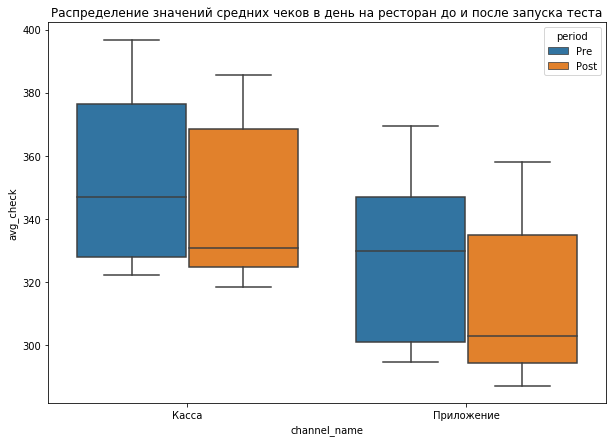

In [39]:
plt.figure(figsize=(10, 7))
plt.title('Распределение значений средних чеков в день на ресторан до и после запуска теста')
sns.boxplot(x='channel_name', y='avg_check', hue='period', data=ars);

Со средним чеком обратная ситуация. средний чек упал после запуска теста.

### GP - gross profit (маржа в день на ресторан, руб)<a id="step8">

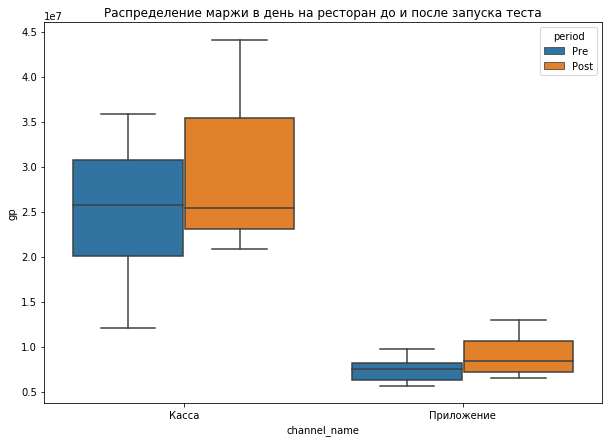

In [40]:
plt.figure(figsize=(10, 7))
plt.title('Распределение маржи в день на ресторан до и после запуска теста')
sns.boxplot(x='channel_name', y='gp', hue='period', data=ars);

Маржа в день на ресторан увеличилась после запуска теста.

### Изменение средней доли продаж чизбургера<a id="step9">

#### Выделим названия чизбургеров из списка транзакций 

In [41]:
cheeseburger = auv.query('dish_name.str.contains("Чизбургер")', engine='python').reset_index()
#сохраним названия, в которых присутствует слово чизбергер в список
cheeseburger_list = cheeseburger['dish_name'].unique().tolist()
cheeseburger_list

['Двойной Чизбургер', 'Лонг Чизбургер', 'Чизбургер']

In [42]:
#напишем функцию для нового столбца, если в столбце dish_name названия совпадают со списком cheesburger_list,
# то в столбец запишем 1, иначе 0
def cheese(values):
    if values in cheeseburger_list:
        return 1
    else:
        return 0

In [43]:
auv['cheese'] = auv['dish_name'].apply(cheese)

Посчитаем суммарные продажи единиц продукции 'Двойной Чизбургер', 'Лонг Чизбургер', 'Чизбургер' по дням

In [44]:
auv_sum_cheese = auv[auv['cheese'] == 1].groupby(['day_id', 'channel_name',
                                                 'period']).agg({'auv':'sum'}).reset_index()

Посчитаем суммарные продажи единиц продукции в день на ресторан 

In [45]:
auv_sum_all_menu = auv.groupby(['day_id', 'channel_name', 'period']).agg({'auv':'sum'}).reset_index()

#### Посчитаем долю чизбургеров в ежедневных продажах

In [46]:
auv_share_cheese = auv_sum_all_menu.merge(auv_sum_cheese, how='left', on=['day_id', 'channel_name', 'period'])

In [47]:
auv_share_cheese = auv_share_cheese.rename(columns={'auv_x':'auv_all', 'auv_y':'auv_cheese'})

In [48]:
auv_share_cheese['cheese_share'] = auv_share_cheese['auv_cheese'] / auv_share_cheese['auv_all'] * 100

In [49]:
auv_share_cheese.head(2)

,day_id,channel_name,period,auv_all,auv_cheese,cheese_share
0,2021-01-01,Касса,Pre,957.37,48.38,5.053428
1,2021-01-02,Касса,Pre,1086.57,34.25,3.152121


Визуализируем распределение долей чизбургеров в общем количестве проданных единиц продукции

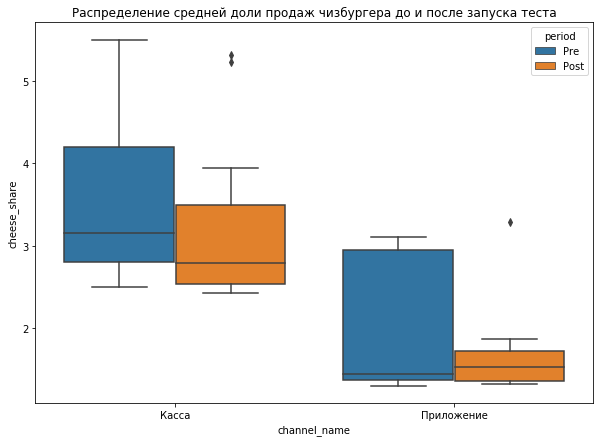

In [50]:
plt.figure(figsize=(10, 7))
plt.title('Распределение средней доли продаж чизбургера до и после запуска теста')
sns.boxplot(x='channel_name', y='cheese_share', hue='period', data=auv_share_cheese);

Доля продаж чизбургеров в общем объеме продаж в натуральном выражении снизилась после запуска теста.

#### Посмотрим как изменилось количество чизбургеров в составе комбо<a id="step10">

Посчитаем "конверсию в комбо-чизбургеры" (долю чизбургров в составе комбо) по кассе до теста и после запуска

Для кассы:

In [51]:
#посчитаем количество чизбургеров всего и в комбо через кассу до и после запуска теста
cheese_pre_cash = pd.Series(cheeseburger[(cheeseburger['period'] == 'Pre') 
                            & (cheeseburger['channel_name'] == 'Касса')]['index'].nunique())
combo_cheese_pre_cash = pd.Series(cheeseburger[(cheeseburger['period'] == 'Pre') & (cheeseburger['action_id'] == 1) 
                            & (cheeseburger['channel_name'] == 'Касса')]['index'].nunique())
cheese_post_cash = pd.Series(cheeseburger[(cheeseburger['period'] == 'Post') 
                            & (cheeseburger['channel_name'] == 'Касса')]['index'].nunique())
combo_cheese_post_cash = pd.Series(cheeseburger[(cheeseburger['period'] == 'Post') & (cheeseburger['action_id'] == 1) 
                            & (cheeseburger['channel_name'] == 'Касса')]['index'].nunique())

In [52]:
#сохраним количество чизбургеров всего и в комбо через кассу до и после запуска теста в df
trials = np.array([cheese_pre_cash, cheese_post_cash])
successes = np.array([combo_cheese_pre_cash, combo_cheese_post_cash])
trials_successes_cash = np.concatenate([trials, successes], axis=1)
trials_successes_cash
columns = ['trials', 'successes']
trials_successes_cash = pd.DataFrame(data=trials_successes_cash, columns=columns)
trials_successes_cash['conversion'] = trials_successes_cash['successes'] / trials_successes_cash['trials']
trials_successes_cash

,trials,successes,conversion
0,163,93,0.570552
1,152,90,0.592105


После запуска теста доля покупок чизбургеров в комбо по кассе, относительно общего количества покупок чизбургеров, выросла.

Для приложения:

In [53]:
#посчитаем количество чизбургеров всего и в комбо через приложение до и после запуска теста
cheese_pre_app = pd.Series(cheeseburger[(cheeseburger['period'] == 'Pre') 
                            & (cheeseburger['channel_name'] == 'Приложение')]['index'].nunique())
combo_cheese_pre_app = pd.Series(cheeseburger[(cheeseburger['period'] == 'Pre') & (cheeseburger['action_id'] == 1) 
                            & (cheeseburger['channel_name'] == 'Приложение')]['index'].nunique())
cheese_post_app = pd.Series(cheeseburger[(cheeseburger['period'] == 'Post') 
                            & (cheeseburger['channel_name'] == 'Приложение')]['index'].nunique())
combo_cheese_post_app = pd.Series(cheeseburger[(cheeseburger['period'] == 'Post') & (cheeseburger['action_id']==1) 
                            & (cheeseburger['channel_name'] == 'Приложение')]['index'].nunique())

In [54]:
#сохраним количество чизбургеров всего и в комбо через приложение до и после запуска теста в df
trials = np.array([cheese_pre_app, cheese_post_app])
successes = np.array([combo_cheese_pre_app, combo_cheese_post_app])
trials_successes_app = np.concatenate([trials, successes], axis=1)
trials_successes_app
columns = ['trials', 'successes']
trials_successes_app = pd.DataFrame(data=trials_successes_app, columns=columns)
trials_successes_app['conversion'] = trials_successes_app['successes'] / trials_successes_app['trials']
trials_successes_app

,trials,successes,conversion
0,129,60,0.465116
1,135,74,0.548148


После запуска теста доля покупок чизбургеров в комбо в приложении, относительно общего количества покупок чизбургеров, выросла.

## Проверка гипотез<a id="step11">

### Z-критерий<a id="step12">
#### Гипотезы:  
#### H0: Нет оснований считать доли разными 
#### H1: Между долями до и после запуска теста есть значимая разница   

Проверим статистическую разницу долей покупок чизбургеров в комбо **на кассе** z-критерием

In [55]:
alpha = 0.05
def pvalue(row):
    for i in range(len(row)):
        trials = row['trials']
        successes = row['successes']
        p1 = successes[0] / trials[0]
        p2 = successes[1] / trials[1]
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
        difference = p1 - p2
        z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

p_value = pvalue(trials_successes_cash)
print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.6984542861138627
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим статистическую разницу долей покупок чизбургеров в комбо **в приложении** z-критерием

In [56]:
alpha = 0.05
def pvalue(row):
    for i in range(len(row)):
        trials = row['trials']
        successes = row['successes']
        p1 = successes[0] / trials[0]
        p2 = successes[1] / trials[1]
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
        difference = p1 - p2
        z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

p_value = pvalue(trials_successes_app)
print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.17736441173356954
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Непараметрический тест Уилкоксона-Манна-Уитни.<a id="step13">
#### Гипотезы:  
#### HO: Между средними значениями до и после запуска теста нет различия  
#### H1: Между средними значениями до и после запуска теста есть различия

### ARS - average retail sales (средняя выручка в день на ресторан, руб)<a id="step14">

#### Для Кассы

In [57]:
ars_pre_cash = ars[(ars['period'] == 'Pre') & (ars['channel_name'] == 'Касса')]['ars'].tolist()
ars_post_cash = ars[(ars['period'] == 'Post') & (ars['channel_name'] == 'Касса')]['ars'].tolist()

In [58]:
alpha = 0.05
results = st.mannwhitneyu(ars_pre_cash, ars_post_cash)
print('pvalue: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

pvalue:  0.07355190243582417
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Значит нельзя сделать вывод, что между средней выручкой до и после запуска теста есть различие.

#### Для приложения

In [59]:
ars_pre_app = ars[(ars['period'] == 'Pre') & (ars['channel_name'] == 'Приложение')]['ars'].tolist()
ars_post_app = ars[(ars['period'] == 'Post') & (ars['channel_name'] == 'Приложение')]['ars'].tolist()

In [60]:
alpha = 0.05
results = st.mannwhitneyu(ars_pre_app, ars_post_app)
print('pvalue: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

pvalue:  0.005157336201168999
Отвергаем нулевую гипотезу: разница статистически значима


### ART - average retail traffic (среднее кол-во чеков в день на ресторан)<a id="step15">

#### Для Кассы

In [61]:
art_pre_cash = ars[(ars['period'] == 'Pre') & (ars['channel_name'] == 'Касса')]['art'].tolist()
art_post_cash = ars[(ars['period'] == 'Post') & (ars['channel_name'] == 'Касса')]['art'].tolist()

In [62]:
alpha = 0.05
results = st.mannwhitneyu(art_pre_cash, art_post_cash)
print('pvalue: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

pvalue:  0.017907628371345328
Отвергаем нулевую гипотезу: разница статистически значима


#### Для Приложения

In [63]:
art_pre_app = ars[(ars['period'] == 'Pre') & (ars['channel_name'] == 'Приложение')]['art'].tolist()
art_post_app = ars[(ars['period'] == 'Post') & (ars['channel_name'] == 'Приложение')]['art'].tolist()

In [64]:
alpha = 0.05
results = st.mannwhitneyu(art_pre_app, art_post_app)
print('pvalue: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

pvalue:  8.028393388331248e-07
Отвергаем нулевую гипотезу: разница статистически значима


### ARC - average retail check (средний чек в день на ресторан, руб)<a id="step16">

#### Для Кассы

In [65]:
avg_check_pre_cash = ars[(ars['period'] == 'Pre') & (ars['channel_name'] == 'Касса')]['avg_check'].tolist()
avg_check_post_cash = ars[(ars['period'] == 'Post') & (ars['channel_name'] == 'Касса')]['avg_check'].tolist()

In [66]:
alpha = 0.05
results = st.mannwhitneyu(avg_check_pre_cash, avg_check_post_cash)
print('pvalue: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

pvalue:  0.029875604680339864
Отвергаем нулевую гипотезу: разница статистически значима


#### Для приложения

In [67]:
avg_check_pre_app = ars[(ars['period'] == 'Pre') & (ars['channel_name'] == 'Приложение')]['avg_check'].tolist()
avg_check_post_app = ars[(ars['period'] == 'Post') & (ars['channel_name'] == 'Приложение')]['avg_check'].tolist()

In [68]:
alpha = 0.05
results = st.mannwhitneyu(avg_check_pre_app, avg_check_post_app)
print('pvalue: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

pvalue:  0.012550641364667554
Отвергаем нулевую гипотезу: разница статистически значима


### GP - gross profit (маржа в день на ресторан, руб)<a id="step17">

#### Для Кассы

In [69]:
gp_pre_cash = ars[(ars['period'] == 'Pre') & (ars['channel_name'] == 'Касса')]['gp'].tolist()
gp_post_cash = ars[(ars['period'] == 'Post') & (ars['channel_name'] == 'Касса')]['gp'].tolist()

In [70]:
alpha = 0.05
results = st.mannwhitneyu(gp_pre_cash, gp_post_cash)
print('pvalue: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

pvalue:  0.03400655172809331
Отвергаем нулевую гипотезу: разница статистически значима


#### Для Приложения

In [71]:
gp_pre_app = ars[(ars['period'] == 'Pre') & (ars['channel_name'] == 'Приложение')]['gp'].tolist()
gp_post_app = ars[(ars['period'] == 'Post') & (ars['channel_name'] == 'Приложение')]['gp'].tolist()

In [72]:
alpha = 0.05
results = st.mannwhitneyu(gp_pre_app, gp_post_app)
print('pvalue: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

pvalue:  0.0007984433525880062
Отвергаем нулевую гипотезу: разница статистически значима


### Изменение средней доли продаж чизбургера<a id="step18">

#### Для Кассы

In [73]:
cheese_pre_cash = auv_share_cheese[(auv_share_cheese['period'] == 'Pre') 
                                   & (auv_share_cheese['channel_name'] == 'Касса')]['cheese_share'].tolist()
cheese_post_cash = auv_share_cheese[(auv_share_cheese['period'] == 'Post')
                                    & (auv_share_cheese['channel_name'] == 'Касса')]['cheese_share'].tolist()

In [74]:
alpha = 0.05
results = st.mannwhitneyu(cheese_pre_cash, cheese_post_cash)
print('pvalue: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

pvalue:  0.04502976347126253
Отвергаем нулевую гипотезу: разница статистически значима


#### Для Приложения

In [75]:
cheese_pre_app = auv_share_cheese[(auv_share_cheese['period'] == 'Pre') 
                                   & (auv_share_cheese['channel_name'] == 'Приложение')]['cheese_share'].tolist()
cheese_post_app = auv_share_cheese[(auv_share_cheese['period'] == 'Post')
                                    & (auv_share_cheese['channel_name'] == 'Приложение')]['cheese_share'].tolist()

In [76]:
alpha = 0.05
results = st.mannwhitneyu(cheese_pre_app, cheese_post_app)
print('pvalue: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

pvalue:  0.4324968530822437
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


## Вывод<a id="step19">

По результатам проведенного теста можно следать следующие выводы:  
- **ARS** - average retail sales (средняя выручка в день на ресторан, руб):
    - по кассе - нельзя сделать вывод, что средняя выручка изменилась
    - в приложении - после запуска теста выручка увеличилась
- **ART** - average retail traffic (среднее кол-во чеков в день на ресторан):
    - по кассе - увеличилось после запуска теста
    - в приложении - увеличилось после запуска теста
- **ARC** - average retail check (средний чек в день на ресторан, руб):
    - по кассе - средний чек уменьшился после запуска теста
    - в приложении - средний чек уменьшился после запуска теста
- **GP**  - gross profit (маржа в день на ресторан, руб):
    - по кассе - средняя маржа в день на ресторан увеличилась после запуска теста
    - в приложении - средняя маржа в день на ресторан увеличилась после запуска теста
- изменение средней **доли продаж чизбургеров**:
    - по кассе - доля чизбургеров в общем количестве позиций уменьшилась после запуска теста
    - в приложении - доля продаж чизбургеров не изменилась


Итого вывод по кассе - количество чеков увеличилось, но средний чек упал, в результате выручка не изменилась, но маржа увеличилась. А доля чизбургеров в чеках уменьшилась, возможно потому что выросла доля сопутствующих чизбургеру товаров.  
Итого вывод по приложению - выручка, среднее количество чеков, маржа увеличились. Но средний чек упал, а доля продаж чизбургеров не изменилась. Доля продаж чизбургеров в комбо увеличилась, но мы не можем считать это изменение значимым.

Возможно, стоит изменения, предложенные в тесте, внедрить для приложений. Но для касс эти изменения не оказывают сильного влияния на улучшение бизнес показателей.